In [1]:
import matplotlib.pyplot as plt
import xarray
from netCDF4 import Dataset 
import os
import cftime
import ipywidgets as widgets
import glob, numpy

In [2]:
# case run output directories
output_rootdir=os.path.expanduser('~')+'/output/cime_run_dirs/'
cases=numpy.asarray(glob.glob("%s*20TR*" % output_rootdir))
cases=[x.split('/')[-1] for x in cases]
cases_dropdown = widgets.Dropdown(options=cases,
                                description='Chose Case Name:',
                                style={'description_width':'auto'},
                                layout={'width':'max-content'},
                                disabled=False)

In [3]:
display(cases_dropdown)

Dropdown(description='Chose Case Name:', layout=Layout(width='max-content'), options=('My_AK-K64G_ICB20TRCNPRD…

In [4]:
#files
output_casedir=output_rootdir+cases_dropdown.value+'/run/'
filenames=numpy.asarray(glob.glob("%s*.elm.h?.*.nc" % output_casedir))
filenames=sorted([x.split('/')[-1] for x in filenames])
if(os.path.exists(output_casedir+'ELM_output.nc')): filenames.insert(0,'ELM_output.nc')
ncfiles_dropdown = widgets.Dropdown(options=filenames,
                                description='Choose Output File:', 
                                style={'description_width':'auto'},
                                layout={'width':'max-content'},
                                value='ELM_output.nc',
                                disabled=False)

In [5]:
display(ncfiles_dropdown)

Dropdown(description='Choose Output File:', layout=Layout(width='max-content'), options=('ELM_output.nc', 'My_…

In [6]:
output_file=output_casedir+ncfiles_dropdown.value
#hard-wired output file path/name - editable
#output_file=output_rootdir+'OLMT_AK-K64G_ICB20TRCNPRDCTCBC/run/ELM_output.nc'

In [7]:
fnc=Dataset(output_file)
vars=fnc.variables
vars_names=vars.keys()
vars_dims={}; vars_units={};
for v in vars: 
    vars_dims[v]=vars[v].dimensions
    if(hasattr(vars[v], 'units')):
        vars_units[v]=vars[v].units
    else:
        vars_units[v]='-'    
fnc.close()
vars_dropdown = widgets.Dropdown(options=vars_names,
                                description='Choose Variable Name',
                                style={'description_width':'auto'},
                                value='GPP',
                                layout={'width':'max-content'},
                                disabled=False)


In [8]:
display(vars_dropdown)

Dropdown(description='Choose Variable Name', index=73, layout=Layout(width='max-content'), options=('levgrnd',…

In [9]:

### user inputs for variable NAME, UNIT, scaling, Year starting and ending for plotting

# user-forced, i.e. NOT by drop-down above,varialbe name in ELM_output.nc to plot
variable_name_user = ''  
#variable_name_user = 'TLAI'  

if((vars_dropdown.value=='' or 'time' not in vars_dims[vars_dropdown.value]) \
   and variable_name_user==''):
    variable_name='GPP'          
elif(variable_name_user==''):
    variable_name=vars_dropdown.value
else:
    variable_name=variable_name_user


variable_unit=''             # user-defined units, '' for that from ELM_output.nc
#variable_unit='ugC/m2/s'     # user-defined units, '' for that from ELM_output.nc

variable_multiplier=1         # scaling original data by multiplying this scalor
#variable_multiplier=1.e6     # scaling original data by multiplying this scalor

yr_start = -9999              # -9999 for default start year in ELM_output.nc
#yr_start = 1850              # -9999 for default start year in ELM_output.nc
yr_end = -9999               # -9999 for default end year in ELM_output.nc
#yr_end = 1850               # -9999 for default end year in ELM_output.nc

In [10]:
output=xarray.open_dataset(output_file).squeeze()

In [11]:
if 'time' in vars_dims[variable_name]:
    time = output['time']  ### time dimension, put in unit of years
    if(yr_start!=-9999):
        t0 = cftime.DatetimeNoLeap(yr_start, 1, 1, 0, 0, 0, 0, has_year_zero=True)
        time=time.where(time.time>t0, drop=True)
    if(yr_end!=-9999):
        t1 = cftime.DatetimeNoLeap(yr_end+1, 1, 1, 0, 0, 0, 0, has_year_zero=True)
        time=time.where(time.time<t1, drop=True)
else:
    print("NOT a time-series variable: ", variable_name)
    
if 'levgrnd' in vars_dims[variable_name]:
    soil_depth=output['levgrnd']
    #print(soil_depth)
if 'levdcmp' in vars_dims[variable_name]:
    soil_depth=output['levdcmp']
    #print(soil_depth)
if 'pft' in vars_dims[variable_name]:
    pft_index=output['pft']
    #print(pft_index)

var_data = output[variable_name]*variable_multiplier
if ('column' in vars_dims[variable_name]):
    var_data = var_data[...,0]

if(yr_start!=-9999 and 'time' in vars_dims[variable_name]):
    t0 = cftime.DatetimeNoLeap(yr_start, 1, 1, 0, 0, 0, 0, has_year_zero=True)
    var_data=var_data.where(var_data.time>t0, drop=True)
if(yr_end!=-9999 and 'time' in vars_dims[variable_name]):
    t1 = cftime.DatetimeNoLeap(yr_end+1, 1, 1, 0, 0, 0, 0, has_year_zero=True)
    var_data=var_data.where(var_data.time<t1, drop=True)



if variable_unit=='':
    var_unit = vars_units[variable_name]
    if variable_multiplier!=1: var_unit=str(1.0/variable_multiplier)+var_unit
else:
    var_unit = variable_unit


Text(0, 0.5, 'GPP (gC/m^2/s)')

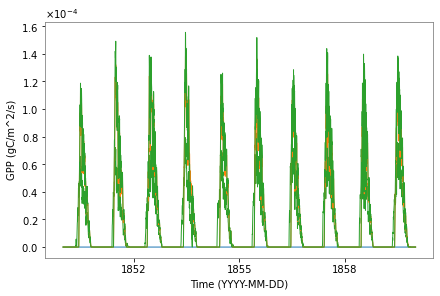

In [12]:
plt.plot(time, var_data, label=variable_name)

#if multiple PFTs, pick its index, e.g. 11 (started from 0)
#plt.plot(time, var_data[...,11], label=variable_name)

#if layered soil variables, pick specified layer, e.g. 4 (started from 0)
#plt.plot(time, var_data[...,4], label=variable_name)

plt.xlabel(''.join(['Time (YYYY-MM-DD)']))
plt.ylabel(''.join([variable_name,' (',var_unit, ')']))